In [99]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [101]:
PATH = 'D:/Algoritmos/Interfaz_Grafica/Challenge/'
TRAIN_PATH = 'D:/Algoritmos/Interfaz_Grafica/Challenge/train/'
TRAIN_MASKS_PATH = 'D:/Algoritmos/Interfaz_Grafica/Challenge/train_masks/'
TEST_PATH = 'D:/Algoritmos/Interfaz_Grafica/Challenge/test/'

In [102]:
# Se hereda de la clase Dataset de Pytorch
class PCG_Dataset(Dataset):
    def __init__(self, data, mask=None, pcg_transforms=None, mask_transforms=None):
        '''
        data - train data path (Son rutas )
        masks - train masks path (son rutas )
        '''
        self.train_data = data     # guarda rutas de señales 
        self.train_masks = mask    # guarda rutas de mascaras

        
        self.pcg_transforms = pcg_transforms         # para data augmentation. 
        self.mask_transforms = mask_transforms       # ademas convierte a tensores de pytorch

        
        self.pcgs = sorted(os.listdir(self.train_data), key=len)  # son todas las señales del directroria de train_data, ademas esta ordenada
        self.masks = sorted(os.listdir(self.train_masks), key=len)  # son todas las mascaras del directroria de train_masks, ademas esta ordenada

        
    def __len__(self):
        if (self.train_masks) is not None:
            assert (len(self.pcgs))==len(self.masks), 'not the same number of images and masks'   # si no hay la misma cantidad de señales y mascaras saca el mensaje
        return len(self.pcgs)
        
    # regresa un elemento del dataset en la posicion del idx
    # tambien nos permite aplicar las transformaciones que necesitemos en el dataset
    def __getitem__(self, idx):          
        pcg_name = os.path.join(self.train_data, self.pcgs[idx])  # concatena la ruta con el nombre de la señal en la posicion idx   
        
        pcg = np.genfromtxt(pcg_name, dtype=float, delimiter=',')  # abro el .csv
        
        trans = torch.from_numpy(pcg)                              # convierto a tensor                                         
        
        if self.pcg_transforms is not None:                        # si hay transoformaciones, las aplica y convierte a tensor
            pcg = self.pcg_transforms(pcg)
        else:
            pcg =torch.from_numpy(pcg)
            
            
        pcg_max = pcg.max().item()                            #normaliza el pcg  
        pcg_min = pcg.min().item()
        pcg = (pcg - pcg_min)/(pcg_max - pcg_min)             # si no hay transformacion solo convierte a tensor
        pcg = pcg[None,:]

        
        if self.train_masks is not None:                                 # chequea si hay mascaras, si hay, las carga
            mask_name = os.path.join(self.train_masks, self.masks[idx])  
            mask = np.genfromtxt(mask_name, dtype=float, delimiter=',')                  
            
            if self.mask_transforms is not None:                    # si hay transoformaciones, las aplica y convierte a tensor
                mask = self.mask1_transforms(mask1)
            else:
                mask = torch.from_numpy(mask)                       # si no hay transformacion solo convierte a tensor
                mask = mask[None, :]
            
        else:
            return pcg                                        # si no existen las mascaras, devuelve la señal
               
        
        return pcg, mask                                   # devuelve imagen y mascara 

In [103]:
# crea el dataset: recibe ruta de entrenamiento, ruta de las mascaras para entrenamiento y las transformaciones.
full_dataset = PCG_Dataset(TRAIN_PATH,TRAIN_MASKS_PATH)

In [104]:
BATCH_SIZE = 8                                         # tamabio del batch
TRAIN_SIZE = int(np.ceil(len(full_dataset) * 0.7))                # el 70% del dataset lo usa para entrenamiento
VAL_SIZE =  int((len(full_dataset) - TRAIN_SIZE)/2)    # el 30% restante lo usa para validacion se divide en mitades para validacion y test
TEST_SIZE = int((len(full_dataset) - TRAIN_SIZE)/2) 

In [105]:
print("Tamaños")
print(len(full_dataset))
print(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)           

Tamaños
13200
9240 1980 1980


In [106]:
# del full dataset usa el random split para obtener los conjuntos de entrenamiento y validacion y test
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

In [107]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

9240 1980 1980


In [108]:
# se crean los data loader para entrenamiento y validacion y test
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)      # con shuffle
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)          # con shuffle
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)       # sin shuffle

In [109]:
# el dataloader permite iterar dentro del objeto
pcgs, mask = next(iter(train_loader))
print(pcgs.shape, mask.shape)

torch.Size([8, 1, 1024]) torch.Size([8, 1, 1024])


In [110]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==3: break

0 torch.Size([8, 1, 1024]) torch.Size([8, 1, 1024])
1 torch.Size([8, 1, 1024]) torch.Size([8, 1, 1024])
2 torch.Size([8, 1, 1024]) torch.Size([8, 1, 1024])
3 torch.Size([8, 1, 1024]) torch.Size([8, 1, 1024])


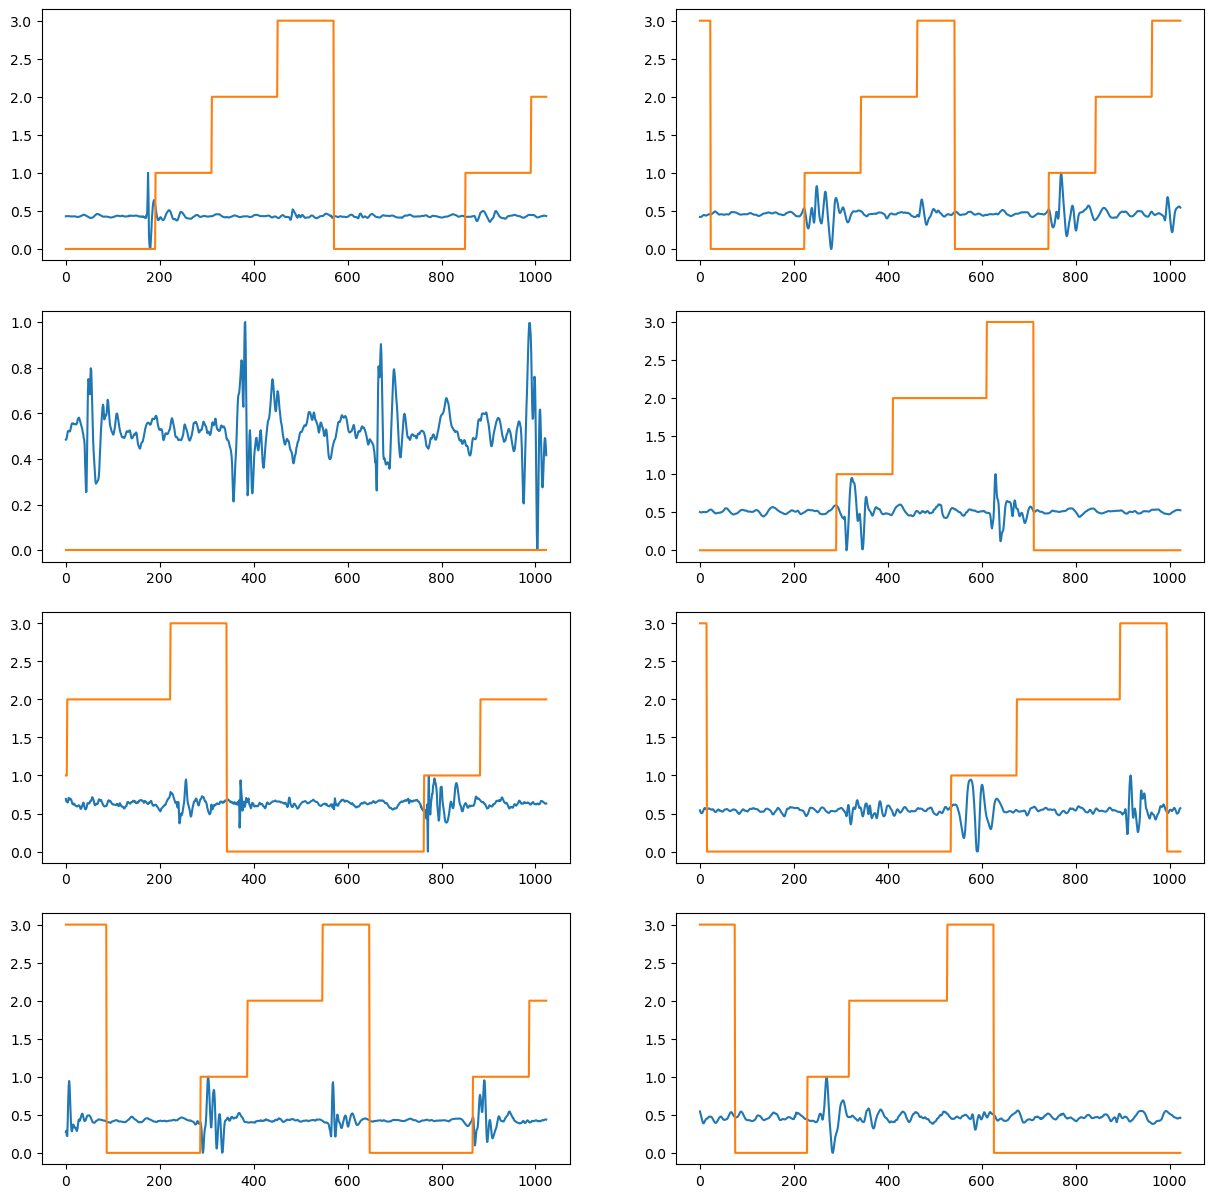

In [111]:
# mostramos las seniales

pcgs, mask = next(iter(train_loader))

def plot_mini_batch(pcgs, mask):
    plt.figure(figsize=(15,15))
    for i in range(BATCH_SIZE):             # hasta 8        
        plt.subplot(4, 2,i+1)               # subplot nro filas, nro columnas, posicion. La primera imagen empieza en la pos=1 
        
        pcgs = pcgs.squeeze(1)
        mask = mask.squeeze(1)
        
        pcg=pcgs.numpy()  
       
        plt.plot(pcg[i,:])     
        plt.plot(mask[i,:])     
        
        plt.axis('On')
        
    plt.savefig('Mascaras.png', dpi=300) 
    plt.show()

plot_mini_batch(pcgs, mask)

In [112]:
def accuracy(model, loader):
    correct = 0             # inicializacion de variables               
    intersection = 0        
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)                                      # ponemos el modelo en el dispositivo
    with torch.no_grad():                                                # no se calculan gradientes
        for x, y in loader:                                      
            x = x.to(device=device, dtype = torch.float32)               # mandamos elementos al dispositivo
            y = y.to(device=device, dtype = torch.long)                  # mandamos elementos al dispositivo 

            y = y.squeeze(1)                                             

            scores = model(x)
            
            cost += F.cross_entropy(input=scores, target=y).item()

            preds  = torch.argmax(scores, dim=1)
            
            correct += (preds == y).sum()
            
            total += torch.numel(preds)
            
            #dice coefficient
            # multiplicacion de la mascara con lo que nos da nuestro modelo
            intersection += (preds&y).sum() 
                
            denom += (preds + y).sum()
            
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds | y).sum()

            iou =(intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou  

In [113]:
len(train_loader)

1155

In [114]:
# funcion de entrenamiento.

def train(model, optimiser, scheduler = None, epochs = 5, store_every = 5):
    model = model.to(device=device)                                            # pasa el modelo a GPU
    train_acc_mb=[]                                                            # creacion de listas para graficar datos
    train_cost_mb =[]
    iou_acc_mb = []
    dice_acc_mb=[]
    val_acc_mb =[]
    val_cost_mb=[]
    test_dice_mb = []
    test_iou_mb = []
    test_cost_mb = []
    test_acc_mb = []
    train_acc_epoch = []
    train_cost_epoch = []
    iou_acc_epoch = []
    dice_acc_epoch = []
    val_acc_epoch = []
    val_cost_epoch = []
    
    test_iou_epoch = []
    test_dice_epoch = []
    test_acc_epoch = []
    test_cost_epoch = []
    for epoch in range(epochs):
        train_correct_num = 0                                        # acumuladores que se resetean en cada epoch
        train_total = 0                                              
        train_cost_acum = 0.                                         
        val_cost_acum = 0
        val_acc_acum = 0
        dice_acum = 0
        iou_acum = 0
        test_acc_acum = 0
        test_cost_acum = 0
        test_iou_acum = 0
        test_dice_acum = 0

        for mb, (x, y) in enumerate(train_loader, start=1):          # iteracion para cada mini batch (mb)
            model.train()                                            # pone el modelo en modo entrenamiento 
            x = x.to(device=device, dtype=torch.float32)             # pone minibatches en el dispositivo
            y = y.to(device=device, dtype=torch.long)                # para poder calcular la funcion de costo se elimina la dimension de valor 1
                                                                    

            y = y.squeeze(1)
            
            scores = model(x)                                        # calcula scores (salida lineal de red)
            cost = F.cross_entropy(input=scores, target=y)

            optimiser.zero_grad()                                    # resetea gradientes en caso que haya gradientes acumulados   
            cost.backward()
            optimiser.step()

            train_predictions = torch.argmax(scores, dim=1)          # scores nos devuelve 3 canales. Nos quedamos con el canal que tiene mayor probabilidad. dim=1 es la dimension de los canales
            
            train_correct_num += (train_predictions == y).sum()    
 
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()                          # acumula el costo con .item() extraemos el valor ya que es un tensor de pytorch

            #if mb%store_every == 0:
            val_cost, val_acc, val_dice, val_iou = accuracy(model, val_loader)        # calucla accuracy con el grupo de validacion
            test_cost, test_acc, test_dice, test_iou = accuracy(model, test_loader)   # calucla accuracy con el grupo de test

            val_cost_acum += val_cost
            val_acc_acum += val_acc
            dice_acum += val_dice
            iou_acum += val_iou
            test_dice_acum += test_dice
            test_iou_acum += test_iou
            test_acc_acum += test_acc
            test_cost_acum += test_cost

            train_acc_mb_float = float(train_correct_num)/train_total        # calcula train_acc. Correctos sobre el total
            train_cost_float = float(train_cost_acum)/mb                     # es train_cost_acum normalizado

            val_cost_mb_float = float(val_cost_acum)/mb
            val_acc_mb_float = float(val_acc_acum)/mb
            dice_acc_mb_float = float(dice_acum)/mb
            iou_acc_mb_float = float(iou_acum)/mb
            test_dice_mb_float = float(test_dice_acum)/mb
            test_iou_mb_float = float(test_iou_acum)/mb
            test_cost_mb_float = float(test_cost_acum)/mb
            test_acc_mb_float = float(test_acc_acum)/mb

            print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_float:.3f}, val cost: {val_cost:.3f},'
                  f'train acc: {train_acc_mb_float:.3f}, val acc: {val_acc:.3f},'
                  f'dice: {val_dice:.3f}, iou: {val_iou:.3f}')

            
            train_acc_mb.append(train_acc_mb_float)
            train_cost_mb.append(train_cost_float)
            val_acc_mb.append(val_acc)
            val_cost_mb.append(val_cost)
            dice_acc_mb.append(val_dice.item())
            iou_acc_mb.append(val_iou.item())


            
            test_dice_mb.append(test_dice_mb_float)
            test_iou_mb.append(test_iou_mb_float)
            test_cost_mb.append(test_cost_mb_float)
            test_acc_mb.append(test_acc_mb_float)


        train_acc_epoch.append(train_acc_mb_float) 
        train_cost_epoch.append(train_cost_float) 
        val_acc_epoch.append(val_acc_mb_float) 
        val_cost_epoch.append(val_cost_mb_float) 
        dice_acc_epoch.append(dice_acc_mb_float) 
        iou_acc_epoch.append(iou_acc_mb_float) 


        
        test_acc_epoch.append(test_acc_mb_float) 
        test_cost_epoch.append(test_cost_mb_float) 
        test_dice_epoch.append(test_dice_mb_float) 
        test_iou_epoch.append(test_iou_mb_float)


    return train_acc_mb ,train_cost_mb,val_acc_mb,val_cost_mb, dice_acc_mb, iou_acc_mb, \
            test_acc_mb, test_cost_mb, test_dice_mb, test_iou_mb, train_acc_epoch, train_cost_epoch, \
            val_acc_epoch, val_cost_epoch, dice_acc_epoch, iou_acc_epoch, test_acc_epoch, test_cost_epoch,\
            test_dice_epoch, test_iou_epoch

In [115]:
# bloque con constantes, ya que usa kernel_size=3  , stride=1 y poadding=1 en topos los cosos
# padding =1 es para que queden las señales de salida del mismo tamaño que las de entrada
# ahora cada vez que se use un bloque de convolucion solo se le pasa cantidad de canales de entrada y cantidad de canales de salida
# lo demas ya queda implicito
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv1d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)  # conv 1d Se toma padding de 1 para que quede igual la señal
    def forward(self, x):
        return self.conv1(x)

In [116]:
# hace el bloque de dos convoluciones una detras de la otra

class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),          # convolucion
                           nn.BatchNorm1d(channels_out),                 # batch normalization
                           nn.ReLU(),                                    # funcion de activacion ReLu
            
                           Conv_3_k(channels_out, channels_out),         # convolucion
                           nn.BatchNorm1d(channels_out),                 # batch normalization
                           nn.ReLU(),                                    # funcion de activacion ReLu
                            )
    def forward(self, x):
        return self.double_conv(x)
    
# maxpooling para bajar y volver a hacer la doble convolucion
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool1d(2,2),                               # maxpool
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
 
# aca hace la interpolacion para subir y volver a hacer la doble convolucion

class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),                     # interpolacion 
                        nn.Conv1d(channels_in, channels_in//2, kernel_size=1, stride=1)  # convolucion de 1x1
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)     # concantena a lo largo de la dimension de los canales
        return self.decoder(x)

# aca hace el modelo
    
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels)                             # 64, 1024
        self.down_conv1 = Down_Conv(channels, 2*channels)                                # 128, 512
        self.down_conv2 = Down_Conv(2*channels, 4*channels)                              # 256, 256
        self.down_conv3 = Down_Conv(4*channels, 8*channels)                              # 512, 128
        
        self.middle_conv = Down_Conv(8*channels, 16*channels)                            # 1024, 64 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)                                 # 512, 1024
        self.up_conv2 = Up_Conv(8*channels, 4*channels)                                  # 256, 256
        self.up_conv3 = Up_Conv(4*channels, 2*channels)                                  # 128, 512
        self.up_conv4 = Up_Conv(2*channels, channels)                                    # 64, 1024
        
        self.last_conv = nn.Conv1d(channels, num_classes, kernel_size=1, stride=1)       # 3, 1024
       
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        n = self.last_conv(u4)
        
        return n
    

In [117]:
def test():
    x = torch.randn((8, 1, 1024))
    model = UNET(1, 64, 4)
    return model(x)

In [118]:
preds = test()

In [119]:
print(preds.shape)

torch.Size([8, 4, 1024])


In [120]:
model = UNET(1, 64, 4)                                            # un canal de antrada y 64 filtros, 3 canales de salida
optimiser_unet = torch.optim.Adam(model.parameters(),lr=0.01)     # optimizador Adam, learning rate = 0.01

In [121]:
train_acc_mb ,train_cost_mb,val_acc_mb,val_cost_mb, dice_acc_mb, iou_acc_mb, test_acc_mb, \
test_cost_mb, test_dice_mb, test_iou_mb, train_acc_epoch, train_cost_epoch, val_acc_epoch, \
val_cost_epoch, dice_acc_epoch, iou_acc_epoch, test_acc_epoch, test_cost_epoch, test_dice_epoch,\
test_iou_epoch  = train(model, optimiser_unet)

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('Mini Batch')
plt.plot(train_acc_mb,label='Train')
plt.plot(val_acc_mb,label='Val')
plt.plot(test_acc_mb,label='Test')
plt.legend()
plt.savefig('Accuracy_MiniBatch1.png', dpi=300) 


In [ ]:
plt.figure()
plt.title('IOU')
plt.xlabel('Mini Batch')
plt.plot(iou_acc_mb,label='IOU')
plt.plot(test_iou_mb,label='test IOU')
plt.plot(dice_acc_mb,label='Dice')
plt.plot(test_dice_mb,label='test Dice')
plt.legend()
plt.savefig('IOU_MiniBatch1.png', dpi=300) 

In [ ]:
plt.figure()
plt.title('Cost')
plt.xlabel('Mini Batch')
plt.plot(train_cost_mb,label='Train')
plt.plot(val_cost_mb,label='Val')
plt.plot(test_cost_mb,label='test')
plt.legend()
plt.savefig('Cost_MiniBatch1.png', dpi=300) 

In [ ]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_epoch,label='Train')
plt.plot(val_acc_epoch,label='Val')
plt.plot(test_acc_epoch,label='test')
plt.legend()
plt.savefig('Accuracy_Epoch1.png', dpi=300)

In [ ]:
plt.figure()
plt.title('IOU')
plt.xlabel('Epoch')
plt.plot(iou_acc_epoch,label='IOU')
plt.plot(test_iou_epoch,label='test IOU')
plt.plot(dice_acc_epoch,label='Dice')
plt.plot(test_dice_epoch,label='test Dice')
plt.legend()
plt.savefig('IOU_Epoch1.png', dpi=300) 


In [ ]:
plt.figure()
plt.title('Cost')
plt.xlabel('Epoch')
plt.plot(train_cost_epoch,label='Train')
plt.plot(val_cost_epoch,label='Val')
plt.plot(test_cost_epoch,label='test')
plt.legend()
plt.savefig('Cost_Epoch1.png', dpi=300) 

In [ ]:
#Guardo el modelo

model_path='./model.pth'
torch.save(model.state_dict(),model_path)

In [ ]:
# Cargo el modelo previamente guardado
modelo = UNET(1,64,4)
modelo.load_state_dict(torch.load(model_path))
modelo.eval()

In [ ]:
# mostramos las señales luego del entrenamiento

pcgs_val, mask_val = next(iter(val_loader))
print(pcgs_val.shape, mask_val.shape)

pcgs_val = pcgs_val.to(device, dtype=torch.float32)    # pone imagenes en gpu
model = model.to(device)                               # manda el modelo a GPU
with torch.no_grad():
    scores = model(pcgs_val)                           
    preds = torch.argmax(scores,dim=1).float()


print(preds.shape)
   
pcgs_val = pcgs_val.squeeze(1).cpu().numpy()  
preds = preds.cpu().numpy()
mask_val = mask_val.squeeze(1).cpu().numpy()  


In [ ]:
#Grafico de señales
def plot_mini_batch_salida(pcgs, mask, preds):
    
    mask_base= np.zeros(mask.shape)
    mask_base[mask == 0] = 1
    mask_S1= np.zeros(mask.shape)
    mask_S1[mask == 1] = 1
    mask_S2= np.zeros(mask.shape)
    mask_S2[mask == 2] = 1
    
    preds_base= np.zeros(preds.shape)
    preds_base[preds == 0] = 1
    preds_S1= np.zeros(preds.shape)
    preds_S1[preds == 1] = 1
    preds_S2= np.zeros(preds.shape)
    preds_S2[preds == 2] = 1
    
    plt.figure(figsize=(15,15))
    for i in range(BATCH_SIZE):                    
        plt.subplot(4, 2,i+1)               
        
        
        plt.plot(pcgs[i,:], 'b',label='pcg')     
        plt.plot(mask_base[i,:], 'r',label='mask') 
        plt.plot(preds_base[i,:],'g', label='pred')
  
        
        plt.axis('On')
        plt.legend()
        plt.title('Linea de Base')
    plt.savefig('Linea_de_Base1.png', dpi=300)
    
    plt.figure(figsize=(15,15))
    for i in range(BATCH_SIZE):                     
        plt.subplot(4, 2,i+1)               
        
       
        plt.plot(pcgs[i,:], 'b',label='pcg')     
        plt.plot(mask_S1[i,:], 'r',label='mask') 
        plt.plot(preds_S1[i,:],'g', label='pred')
  
        
        plt.axis('On')
        plt.legend()
        plt.title('S1')
    plt.savefig('S11.png', dpi=300) 
    
    plt.figure(figsize=(15,15))
    for i in range(BATCH_SIZE):                     
        plt.subplot(4, 2,i+1)               
        
       
        plt.plot(pcgs[i,:], 'b',label='pcg')     
        plt.plot(mask_S2[i,:], 'r',label='mask') 
        plt.plot(preds_S2[i,:],'g', label='pred')
  
        
        plt.axis('On')
        plt.legend()
        plt.title('S2')
    plt.savefig('S21.png', dpi=300) 
    plt.show()

In [ ]:
plot_mini_batch_salida(pcgs_val, mask_val, preds)





































































































































































































In [ ]:
#grafico señales de grupo de test
pcgs_test, mask_test = next(iter(test_loader))

pcgs_test = pcgs_test.to(device, dtype=torch.float32)   
modelo = modelo.to(device)                               
with torch.no_grad():
    scores = modelo(pcgs_test)                          
    preds = torch.argmax(scores, dim=1).float()         

pcgs_test = pcgs_test.squeeze(1).cpu().numpy() 
preds = preds.cpu().numpy()                        
mask_test = mask_test.squeeze(1).cpu().numpy()


print(pcgs_test.shape,preds.shape,mask_test.shape)


In [ ]:
plot_mini_batch_salida(pcgs_test, mask_test, preds) 















































































































































































































































































In [ ]:
test_cost_mb


In [ ]:
test_cost_epoch

In [ ]:
test_acc_epoch

In [ ]:
test_acc_mb